# Extract Largest Eigenvalue of Symmetric Matrix with an ODE

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib import cm

In [15]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [16]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=False
save_dir = "../../../tex/02_neural_nets_on_pdes/img/"

# Some shorthands for figure labels/legends
MSE = r"$\mathrm{MSE}_\mathcal{V}$"

In [17]:
def eigenvalue_of_eigenvector(x, A):
    return (x[:,None,:] @ A @ x[:,:,None]).squeeze() / (x[:,None,:] @ x[:,:,None]).squeeze()

In [18]:
# Our test matrix (tridiagonal, symmetrix, toeplitz...a mathematicians dream)
dim = 6
A = np.zeros((dim,dim))
i,j = np.indices(A.shape)
A[i == j] = 2
A[i == j-1] = 1
A[i == j+1] = 1

assert np.allclose(A, A.T, rtol=1e-8, atol=1e-10)
print(f"A = {A}")

#Ground Truth (analytical spectrum available!!!)
eigenvalues_analytical = A[0,0] + 2*np.sqrt(A[0,1]*A[1,0]) * np.cos(np.arange(1, dim+1)*np.pi/(dim+1))
eigenvalues_np, eigenvectors_np = np.linalg.eigh(A)

# Numpy result (sort in descending order)
permutation = eigenvalues_np.argsort()[::-1]
eigenvalues_np = eigenvalues_np[permutation]
eigenvectors_np = eigenvectors_np[permutation]

permutation = eigenvalues_analytical.argsort()[::-1]
eigenvalues_analytical = eigenvalues_analytical[permutation]

print(f"Sp(A) (exact) = {eigenvalues_analytical}")
print(f"Sp(A) (numpy) = {eigenvalues_np}")
print(f"max{{ Sp(A) }} = {np.max(eigenvalues_analytical)}")

A = [[2. 1. 0. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0.]
 [0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 0. 1. 2.]]
Sp(A) (exact) = [3.80193774 3.2469796  2.44504187 1.55495813 0.7530204  0.19806226]
Sp(A) (numpy) = [3.80193774 3.2469796  2.44504187 1.55495813 0.7530204  0.19806226]
max{ Sp(A) } = 3.801937735804838


In [19]:
def f(t, y, A):
    first_term = (y[:,None,:] @ (y[:,None,:] @ y[:,:,None] * A)).squeeze()
    second_term = (y[:,None,:] @ A @ y[:,:,None] @ y[:,None,:]).squeeze()
    return first_term - second_term


fA = lambda t, x: f(t, x.reshape(1,-1), A).squeeze()
x0 = np.random.rand(dim).reshape(1,-1)
x0 /= np.sqrt(x0 @ x0.T)

In [20]:
T = 20
N = 2000
t = np.linspace(0,T,N)
sol = solve_ivp(fA, [0,T], x0.squeeze(), t_eval = t)
print(sol.y.shape)

(6, 2000)


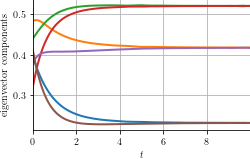

In [24]:
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
for i in range(dim):
    ax.plot(sol.t[sol.t<10], sol.y[i,sol.t<10])
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"eigenvector components")
if save:
    fig.savefig(save_dir + "eigenproblem_ode_component_evolution.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

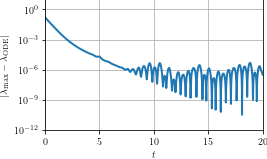

In [25]:
save=True
size = (3.9, 0.618 * 3.9) if save else (10,6)

fig, ax = plt.subplots(figsize=size)
ax.set_yscale("log")
ax.plot(t, np.abs(eigenvalues[0] - eigenvalue_of_eigenvector(sol.y.T,A)))
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$|\lambda_\mathrm{max} - \lambda_\mathrm{ODE}|$")
ax.set_ylim([1e-12,1e1])
plt.show()

if save:
    fig.savefig(save_dir + "eigenproblem_ode_error.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()

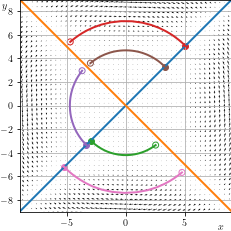

In [26]:
def dstack_product(x, y):
     return np.dstack(np.meshgrid(x, y)).reshape(-1, 2)

save=True

M = 50
dim = 2
A = np.zeros((dim,dim))
i,j = np.indices(A.shape)
A[i == j] = 2
A[i == j-1] = 1
A[i == j+1] = 1

x = y = np.linspace(-10,10,M)
xy = dstack_product(x,y)
dXdt = f(None, xy, A)

X = xy[:,0].reshape(M,M)
Y = xy[:,1].reshape(M,M)
dX = dXdt[:,0].reshape(M,M)
dY = dXdt[:,1].reshape(M,M)

eigenvalues, eigenvectors = np.linalg.eigh(A)
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation,:]

trials = 5
x0s = 12 * np.random.rand(2,trials) - 6
T = 5
N = 2000
t = np.linspace(0,T,N)

size = (3.9, 3.9) if save else (10,6)
fig, ax = plt.subplots(figsize=size)

alpha = np.linspace(-20,20,2)
for i in range(2):
    ax.plot(alpha * eigenvectors[i,0], alpha * eigenvectors[i,1])
    
ax.quiver(X, Y, dX, dY)

for i in range(trials):
    x0 = x0s[:,i]
    sol = solve_ivp(fA, [0,T], x0.squeeze(), t_eval = t)
    line, = ax.plot(sol.y[0,:], sol.y[1,:])
    ax.scatter(sol.y[0,0], sol.y[1,0], edgecolors=line.get_c(), facecolors='none')
    ax.scatter(sol.y[0,-1], sol.y[1,-1], c=line.get_c())

ax.set_xlim([-9,9])
ax.set_ylim([-9,9])
ax.set_xlabel(r"$x$")
ax.xaxis.set_label_coords(.95, -0.05)
ax.set_ylabel(r"$y$", rotation=0)
ax.yaxis.set_label_coords(-0.07, .95)
ax.set_aspect("equal")

if save:
    fig.savefig(save_dir + "eigenproblem_ode_integral_curves.pdf",bbox_inches="tight",pad_inches = 0.02)
else:
    plt.show()